In [12]:
from pyspark.sql import SparkSession
import json
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd



Matplotlib is building the font cache; this may take a moment.


In [ ]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["yelp"]

# Drop old collections if they exist
db["business"].drop()
db["review"].drop()

# === Trim and load only first 100000 businesses ===
with open("data/yelp_academic_dataset_business.json", "r", encoding="utf-8") as f:
    business_data = [json.loads(line) for _, line in zip(range(100000), f)]
db["business"].insert_many(business_data)
print(f"✅ Inserted {len(business_data)} businesses")

# === Trim and load only first 20000 reviews ===
with open("data/yelp_academic_dataset_review.json", "r", encoding="utf-8") as f:
    review_data = [json.loads(line) for _, line in zip(range(20000), f)]
db["review"].insert_many(review_data)
print(f"✅ Inserted {len(review_data)} reviews")

✅ Inserted 100000 businesses
✅ Inserted 20000 reviews


In [ ]:
# === Trim and load only first 50000 reviews ===
with open("data/yelp_academic_dataset_review.json", "r", encoding="utf-8") as f:
    review_data = [json.loads(line) for _, line in zip(range(20000), f)]
db["review"].insert_many(review_data)
print(f"✅ Inserted {len(review_data)} reviews")

In [36]:

spark = SparkSession.builder.appName("YelpProject").getOrCreate()

In [37]:
# Read documents, exclude '_id'
business_docs = list(db["business"].find({}, {"_id": 0}))
review_docs = list(db["review"].find({}, {"_id": 0}))

# Convert to Spark DataFrames
df_business = spark.createDataFrame(business_docs)
df_review = spark.createDataFrame(review_docs)

df_business.show(3)
df_review.show(3)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{ByAppointmentOnl...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                NULL|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{BusinessAcceptsC...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{Thursday -> 8:0-...|      1| 38.551126|  -90.335695|    

In [38]:
#top businesses with highest review counts
top_business=df_business.orderBy("review_count", ascending=False).limit(20)
top_business.show()

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|      112 19th Ave S|{BikeParking -> T...|GXFMD0Z4jEVZBCsbP...|American (Traditi...|    Nashville|{Thursday -> 11:0...|      1|36.1513871523|-86.7966029393|Hattie B’s Hot Ch...|      37203|        6093|  4.5|   TN|
|        441 Royal St|{BikeParking -> T...|VQcCL9PiNL_wkGf-u...|American (New), R...|  New Orleans|{Thursday -> 11:0...|      1|  29.956

In [41]:
from pyspark.sql.functions import avg
#average star rating per city 
avg_rating_per_city = df_business.groupBy("city").agg(avg("stars").alias("avg_rating"))
avg_rating_per_city.show()

#supposed to write a new table for this, but didn't work that well
#avg_rating_per_city.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").option("uri", "mongodb://localhost:27017/yelp.avg_rating_per_city").save()

+-------------------+------------------+
|               city|        avg_rating|
+-------------------+------------------+
|       Harleysville| 3.314516129032258|
|         Westampton|2.9814814814814814|
|        Merion Park|               3.5|
|              Bucks| 4.071428571428571|
|          Worcester|3.5714285714285716|
|        Springfield|3.1224066390041494|
|      Pleasant View|3.0172413793103448|
|            Truckee|               4.7|
|          Frontenac| 3.230769230769231|
|        Marcus Hook|3.6944444444444446|
|    King Of Prussia| 3.066666666666667|
|     Lafayette Hill| 3.842857142857143|
| Indian Rocks Beach|3.8796296296296298|
|      Lawrenceville|              3.25|
|        Cherry Hill|3.4042721518987342|
|         Plainfield|3.3940217391304346|
|           Olivette|3.6136363636363638|
|          Levittown|              3.33|
|         Terra Ceia|               4.0|
|Pittsgrove Township|               4.0|
+-------------------+------------------+
only showing top

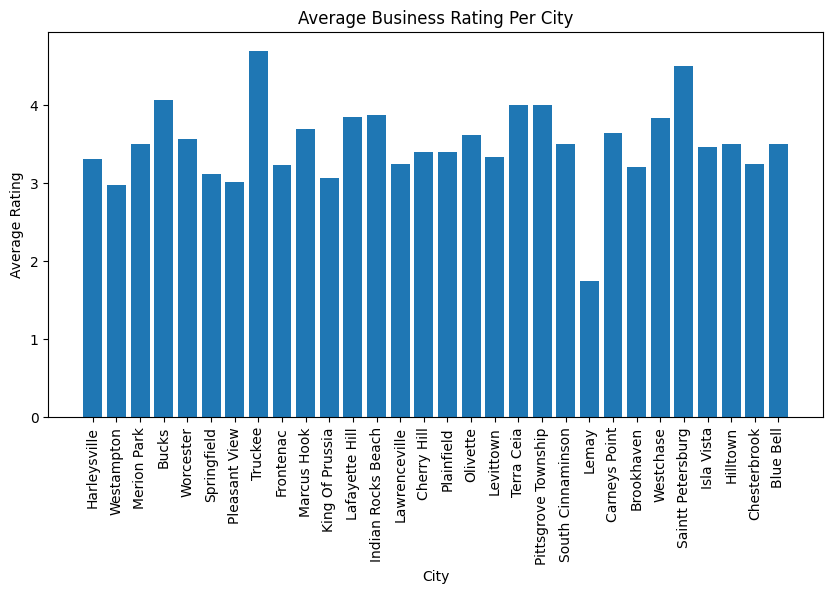

In [42]:

pandas_df = avg_rating_per_city.toPandas()
top_30_cities = pandas_df.head(30)
plt.figure(figsize=(10,5))
plt.bar(top_30_cities["city"], top_30_cities["avg_rating"])
plt.xticks(rotation=90)
plt.xlabel("City")
plt.ylabel("Average Rating")
plt.title("Average Business Rating Per City")
plt.show()

In [43]:
from pyspark.sql.functions import explode, split


category_counts = df_business.withColumn("category", explode(split(df_business["categories"], ", "))) \
                             .groupBy("category").count() \
                             .orderBy("count", ascending=False)

category_counts.show(10) 

+----------------+-----+
|        category|count|
+----------------+-----+
|     Restaurants|34749|
|            Food|18517|
|        Shopping|16277|
|   Home Services| 9622|
|   Beauty & Spas| 9504|
|       Nightlife| 8124|
|Health & Medical| 7835|
|  Local Services| 7470|
|            Bars| 7327|
|      Automotive| 7131|
+----------------+-----+
only showing top 10 rows



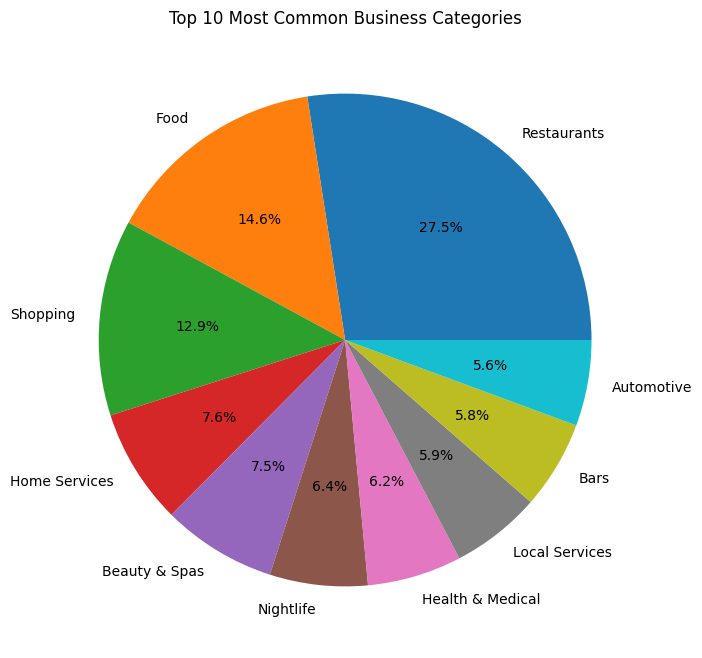

In [44]:
top_categories = category_counts.toPandas().head(10)

plt.figure(figsize=(8, 8))
plt.pie(top_categories["count"], labels=top_categories["category"], autopct="%1.1f%%")
plt.title("Top 10 Most Common Business Categories")
plt.show()

In [45]:
df_business.createOrReplaceTempView("business")
spark.sql("SELECT city, AVG(stars) FROM business GROUP BY city ORDER BY AVG(stars) DESC LIMIT 10").show()

+-------------+----------+
|         city|avg(stars)|
+-------------+----------+
|      Secane |       5.0|
|Pass-a-Grille|       5.0|
|     Norriton|       5.0|
|      Fernley|       5.0|
| phoenixville|       5.0|
| Webster Grvs|       5.0|
|Birchrunville|       5.0|
|       SPARKS|       5.0|
|        Reno |       5.0|
|      Arizona|       5.0|
+-------------+----------+



In [ ]:
pipeline = [
    {"$group": {"_id": "$city", "avg_rating": {"$avg": "$stars"}}},
    {"$sort": {"avg_rating": -1}},
    {"$limit": 10}
]
top_cities = list(db.business.aggregate(pipeline))


AttributeError: 'list' object has no attribute 'show'